In [2]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, ttest_ind
from datetime import datetime
import seaborn as sns

import ipywidgets as widgets
import os

from tqdm.notebook import tqdm

### Sample Size

Напишем функцию для оценки размера выборки. Проверим на искусственных данных, что она работает корректно.

$$n > \dfrac{\left[ \Phi^{-1} \Bigl( 1-\dfrac{\alpha}{2} \Bigr) + \Phi^{-1} \Bigl( 1-\beta \Bigr) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

Реализуем эту формулу для случая равных дисперсий:

In [3]:
def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

def get_sample_size_arb(mu, std, eff=1.01, alpha=0.05, beta=0.2):
    epsilon = (eff - 1) * mu

    return get_sample_size_abs(epsilon, std=std, alpha=alpha, beta=beta)

### MDE

Напишем функцию для оценки размера выборки:

$$\varepsilon > \frac{\left[ \Phi^{-1} \left( 1-\dfrac{\alpha}{2} \right) + \Phi^{-1} \left( 1-\beta \right) \right] \sqrt{ \sigma_X^2 + \sigma_Y^2 }}{\sqrt{n}}$$

Реализуем эту формулу для случая равных дисперсий:

In [4]:
def get_minimal_determinable_effect(std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

### Price of Mistake

$\mu$ и $std$ мы можем оценить по историческим данным, $\alpha$ и $\beta$ — определяем сами допустимые для нас ошибки. 
Как определить ожидаемый эффект, к чему могут привести завышенные ожидания?

Смоделируем ситуации, когда ожидаемый и реальный эффект не совпадают, посмотрим, как будет меняться ошибка второго рода.

In [5]:
def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = ttest_ind(a, b)
    return int(pvalue < alpha)

sample_size = 252



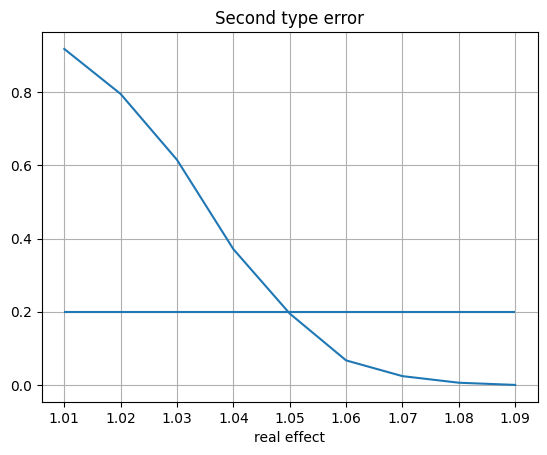

In [8]:
mu = 10
std = 2
eff = 1.05
alpha = 0.05
beta = 0.2

real_effs = np.linspace(1.01, 1.09, 9)


sample_size = get_sample_size_arb(mu, std, eff, alpha, beta)
print(f'sample_size = {sample_size}\n')

second_errors = []
for real_eff in real_effs:
    result_ab = []
    for _ in range(1000):
        a = np.random.normal(mu, std, sample_size)
        b = np.random.normal(mu*real_eff, std, sample_size)
        result_ab.append(check_ttest(a, b))
    second_errors.append(1-np.mean(result_ab))

plt.plot(real_effs, second_errors)
plt.title('Second type error')
plt.hlines(0.2, 1.01, 1.09, label='beta')
plt.xlabel('real effect')
plt.grid()
plt.show()

Получаем, что если мы ошиблись в эффекте на 1%, думали будет 5%, а оказалось 4%, 
то это увеличивает ошибку второго рода в два раза, с 20% до 40%.

Если есть возможность, лучше собирать данные с запасом.

### A/A Testing and P-value Distribution

Давайте напишем вспомогательную функцию. Она будет отрисовывать эмпирическое распределение $p-value$. 

Ниже мы обсудим, какие условия должны быть выполнены, чтобы считалось, что наш тест корректен.

In [9]:
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

#### Type 1 Error Control

Существует теорема, которая гласит, что $p-value$ распределено равномерно от 0 до 1 при условии, 
что нулевая гипотеза $H_0$ верна. 
То есть:

$$p-value | H_0 \sim U[0, 1]$$
$$F_{p-value | H_0}(x) = \mathbb{P}(p\_value < x | H_0) = x$$

Равномерность распределения p-value при верности нулевой гипотезы — это необходимое условие корректной работы стат критерия. 
Мы научились опрелять, контролируется ли вероятность ошибки 1-го рода для заданного дизайна. 
Чтобы проверить равномерность распределения, нужно многократно просимулировать эксперименты без наличия эффекта. 
Мы должны убедиться, что если мы многократно запускаем А/А тесты, то $p-value$ должно иметь равномерное распределение. 


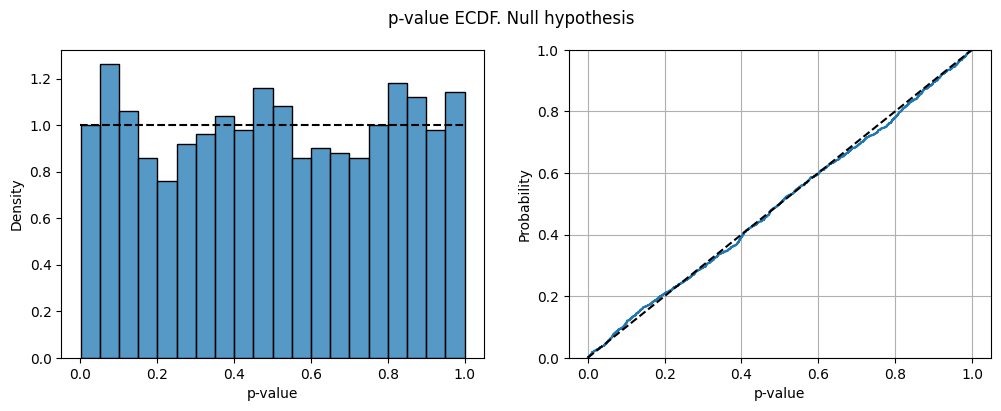

In [10]:
mean = 0
std = 1
sample_size = 100

p_values = []
for _ in range(1000):
    a = np.random.normal(mean, std, sample_size)
    b = np.random.normal(mean, std, sample_size)
    _, p_val = ttest_ind(a, b)
#     p_val = np.random.uniform(0, 1)
    p_values.append(p_val)

plot_pvalue_ecdf(p_values, 'p-value ECDF. Null hypothesis')

Интуитивно это свойство тоже ясно. При отсутствии эффекта мы должны контролировать вероятность ошибки 1-го рода, то есть
* на уровне значимости 0.05 мы должны ошибаться в среднем в 5 случаях из 100;
* на уровне значимости 0.1 мы должны ошибаться в среднем в 10 случаях из 100;
* на уровне значимости 0.2 мы должны ошибаться в среднем в 20 случаях из 100.

Это и есть определение равномерной случайной величины $U[0, 1]$.
$$F_{U[0, 1]}(x) = x$$


#### Type 2 Error Control

Мы научились проверять, контролируется ли вероятность ошибки 1-го рода. 
Например, если бы статистический тест возвращал случайное число от 0 до 1, 
то он бы отлично контролировал вероятность ошибки 1-го рода, но смысла в таком тесте нет. 
Мы переходим к **мощности** теста. 

Что означает, что мощность теста при заданном MDE равна 0.8? Это означает, что если на самом деле эффект, 
равный MDE, присутствует, то мы должны в среднем обнаруживать его в 80 случаях из 100. 
То есть если верна альтернативная гипотеза, то функция распределения $p-value$ должна быть выпуклой 
и равняться мощности теста на заданном уровне значимости.

То есть в нашем примере:
$$F_{p-value | H_1}(\alpha) = \mathbb{P}(p-value < \alpha | H_1) = 1 - \beta$$

Чтобы проверить, обладает ли тест заданной мощностью, нужно многократно просимулировать эксперименты без наличия эффекта, 
к одной из групп добавляя эффект, равный MDE. В этом случае распределие $p-value$ должно быть выпуклым с заданной мощностью.


mde is 0.396


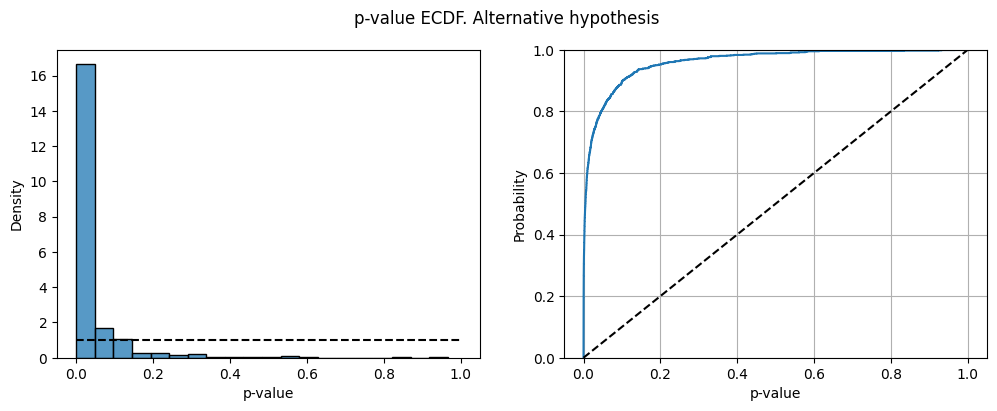

In [11]:
alpha = 0.05
beta = 0.2
mde = get_minimal_determinable_effect(std, sample_size, alpha, beta)
print(f'mde is {np.round(mde, 3)}')

p_values = []
for _ in range(1000):
    a = np.random.normal(mean, std, sample_size)
    b = np.random.normal(mean, std, sample_size) + mde
    _, p_val = ttest_ind(a, b)
    p_values.append(p_val)

plot_pvalue_ecdf(p_values, 'p-value ECDF. Alternative hypothesis')
# по уровню p=0.05 ECDF ≈ 0.8, это значит, что 80% экспериментов были значимы — то есть мощность теста ≈ 0.8 (что соответствует beta = 0.2).
# После p = 0.05:
# Кривая быстро выходит на горизонталь, приближаясь к 1.
# Это говорит о том, что почти все p-value находятся ниже некоторого значения (напр. 0.1–0.2) — опять же, логично при наличии эффекта.

### A/A Testing With Dependent Data

Приведем простой пример, когда нулевая гипотеза верна, то есть на самом деле $\mathbb{E}X = \mathbb{E}Y$, 
но $p-value$ распределено не равномерно. То есть условия применимости t-test не выполнены. 

Для этого, как и в предыдущем примере, многократно сгенерируем две выборки из одного распределения, 
но продублируем их значения несколько раз.


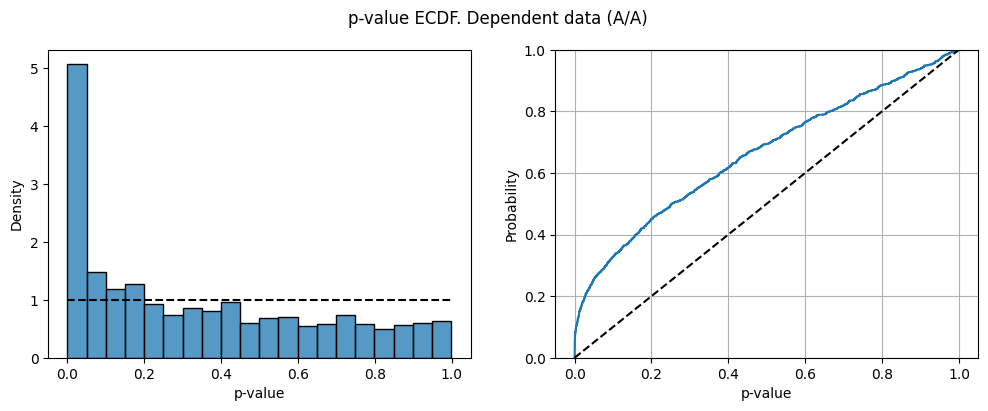

In [18]:
replication_factor = 3
p_values = []
for _ in range(1000):
    a_ = np.random.normal(mean, std, sample_size)
    b_ = np.random.normal(mean, std, sample_size)
    a = np.concatenate([a_] * replication_factor)
    b = np.concatenate([b_] * replication_factor)

    _, p_value = ttest_ind(a, b)
    p_values.append(p_value)

plot_pvalue_ecdf(p_values, 'p-value ECDF. Dependent data (A/A)')

In [17]:
(np.array(p_values) < 0.05).mean()

0.264

Мы видим, что в данном случае вероятность ошибки 1-го рода не контролируется. 
Это означает, что если бы мы слепо применили t-test, взяли то, что возвращает данная функция (фактически, 
это уже не $p-value$, а просто какое-то число от 0 до 1), а затем сравнили с уровнем значимости, 
то при уровне значимости 0.05 вероятность ошибки 1-го рода равнялась бы 0.28 вместо 0.05, 
то есть в 5.5 раз больше!

### Pizzeria's Data

Предположим, мы хотим спроектировать дизайн эксперимента для целевой метрики средний чек:

In [19]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

web_logs = read_database('2022-04-01T12_df_web_logs.csv')

In [20]:
sales = read_database('2022-04-01T12_df_sales.csv')
sales['date'] = pd.to_datetime(sales['date'])
sales.head(3)

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a


sales — таблица с информаций о покупках, одна строка — один заказ. 

1. sale_id — идентификатор покупки;
2. date — дата покупки;
3. count_pizza — количество пицц в заказе;
4. count_drink — количество напитков в заказе;
5. price — стоимость заказа;
6. user_id — идентификатор пользователя.

2022-02-04 10:00:24
2022-04-01 11:59:51
(203847, 6)


<Axes: >

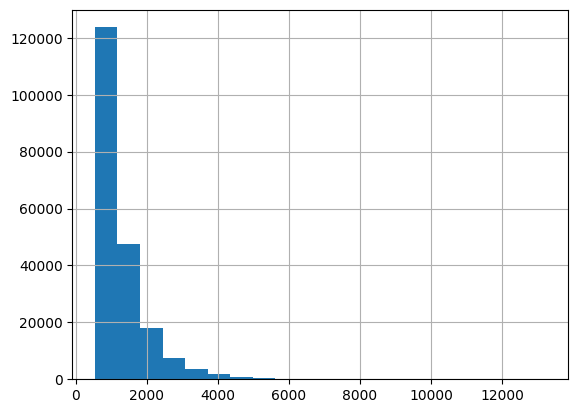

In [21]:
print(sales['date'].min())
print(sales['date'].max())
print(sales.shape)
sales['price'].hist(bins=20)

Предположим, что мы хотим проводить тест в течение 4х недель.

Для этого на историческом промежутке выберем интервал длиной в одну неделю и проведем все расчеты 
для данного промежутка времени. Отметим, что сегодня 1 апреля, поэтому мы взяли неделю непосредственно 
перед запуском эксперимента. Данный подход служит неплохой эвристикой.


In [27]:
sales_hist = sales[
    (sales['date'] >= datetime(2022, 3, 1))
    & (sales['date'] < datetime(2022, 3, 29))
]
sales_hist.shape

(101951, 6)

Чтобы проверить корректность дизайна эксперимента, мы должны многократно просимулировать 
этот эксперимент на исторических данных. Сначала проверим, контролируется ли вероятность ошибки 1-го рода. 
Для этого объектами в нашей выборке будут **чеки**. То есть мы делим всех людей на 2 группы, 
собираем все чеки назвисимо и проводим t-test.

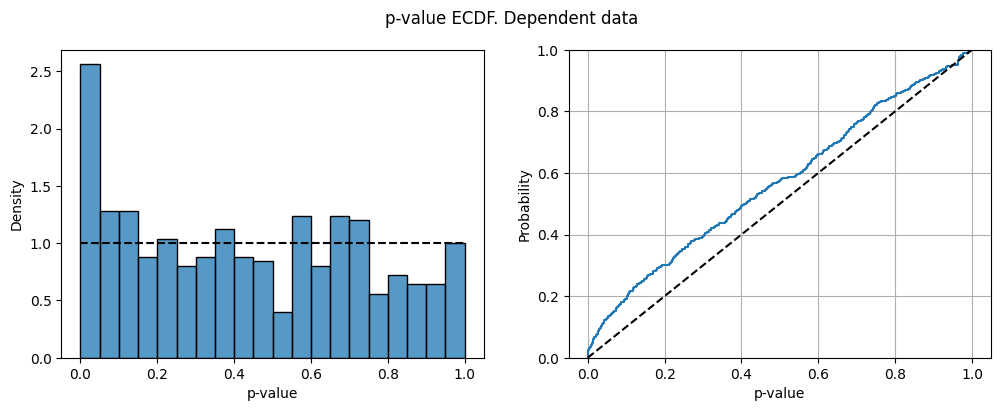

In [28]:
# sales_hist = sales

p_values = []
users = sales_hist['user_id'].unique()
for _ in range(500):
    np.random.shuffle(users)
    group_a, group_b = users[:len(users) // 2], users[len(users) // 2:]
    sales_a = sales_hist[sales_hist['user_id'].isin(group_a)]['price']
    sales_b = sales_hist[sales_hist['user_id'].isin(group_b)]['price']
    _, p_val = ttest_ind(sales_a, sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Dependent data')

In [26]:
(np.array(p_values) < 0.05).mean()

0.046

Видно, что $p-value$ распределено не равномерно. То есть если бы мы бездумно применили t-test к данной выборке, 
то на уровне значимости 0.05 ошибались бы с вероятностью более 0.1. 
Это значит, что мы бы в среднем получали в 2 раза больше ложноположительных результата, чем допускает дизайн эксперимента. 

Такое поведения связано с тем, что выборка не удовлетворяет условиям регулярности t-test, 
в частности, наблюдения не независимы, так как один человек в течение эксперимента может сделать несколько покупок.

Как работать с метриками такого типа мы обсудим на лекции, посвященной метрикам отношения, 
а сейчас просто перейдем к другой метрике. Давайте рассмотрим метрику **средний чек на пользователя**. 
То есть мы сначала для каждого человека посчитаем его средний чек, а затем сравним два набора таких значений. 
Таким образом, наши данные уже будут статистически независимы, так как от каждого пользователя мы получим одно значение, 
а пользователи между собой независимы. После этого повторим процедуру, описанную выше.


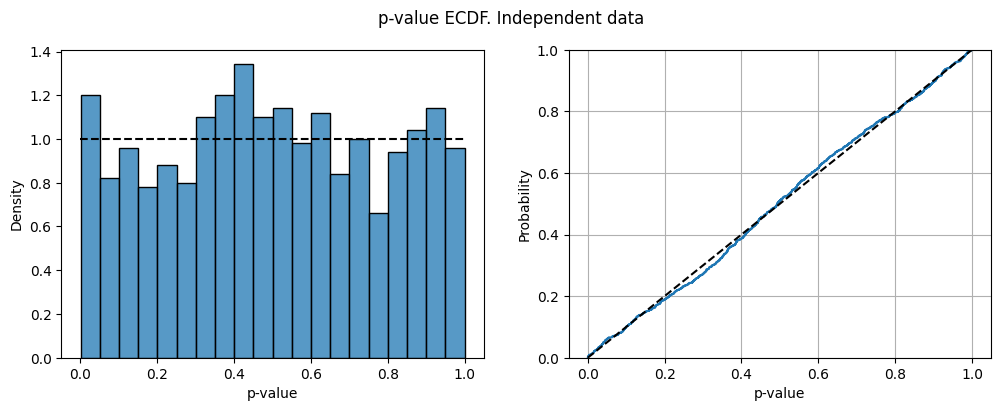

In [31]:
p_values = []
grouped_sales = sales_hist.groupby('user_id')[['price']].mean().reset_index()
users = sales_hist['user_id'].unique()
for _ in range(1000):
    np.random.shuffle(users)
    group_a, group_b = users[:len(users)//2], users[len(users)//2:], 
    sales_a = grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b = grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    _, p_val = ttest_ind(sales_a, sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Independent data')

Видно, что вероятность ошибки 1-го рода контролируется. Но обладает ли наш тест достаточной мощностью?

Давайте проверим это. Для этого посчитаем MDE и будем к одной из групп прибавлять случайный эффект, равный MDE.

In [32]:
mean = grouped_sales['price'].mean()
std = grouped_sales['price'].std()
sample_size = grouped_sales.shape[0] // 2
alpha = 0.05
beta = 0.2

mde = get_minimal_determinable_effect(std, sample_size, alpha, beta)
print(f'mde is {np.round(mde, 3)}')

mde is 15.866


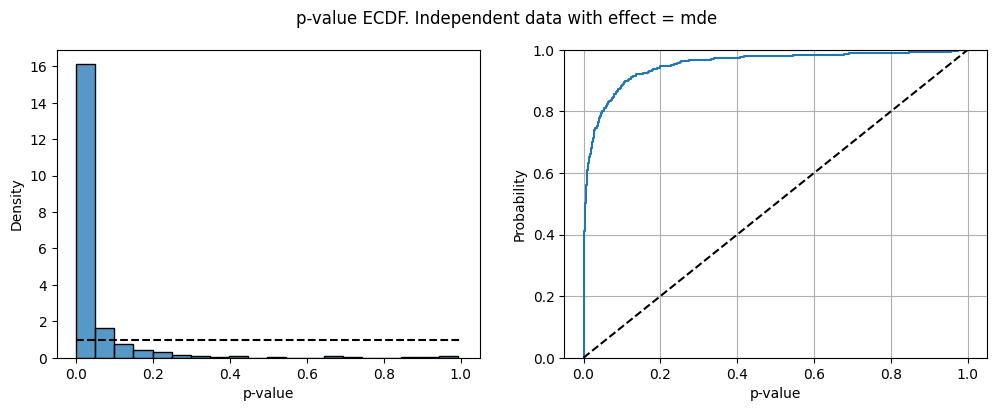

In [33]:
p_values = []
grouped_sales = sales_hist.groupby('user_id')[['price']].mean().reset_index()
users = sales_hist['user_id'].unique()
for _ in range(500):
    np.random.shuffle(users)
    group_a, group_b = users[:len(users) // 2], users[len(users) // 2:]
    sales_a = grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b = grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    sales_b += np.random.normal(mde, std // 10, sales_b.shape)
    _, p_val = ttest_ind(sales_a, sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Independent data with effect = mde')

На уровне значимости 0.05 мы отлавливаем эффект в среднем в 80-ти случаях из 100, 
то есть тест обладает заданной мощностью и дизайн полностью корректен. 

То есть если мы будем проводить тест на всех пользователях в течение 4-х недель на уровне значимости 0.05, 
то вероятность ошибки 1-го рода в действительности равняется 0.05. 
Более того, мы обнаружим эффект равный $MDE=15.8$ в среднем в 80-ти случаях из 100, 
если он на самом деле присутствует, что мы и закладывали в дизайне эксперимента.

### Оценка вероятности ошибок II рода для трёх вариантов добавления эффекта

In [ ]:

# Мы рассмотрели несколько вариантов добавления эффекта. 
# Допустим, в наш А/В-тест попадают все пользователи, совершавшие покупки до 28 марта.

# Целевая метрика — средняя выручка с клиента за время эксперимента. 
# Целевую метрику считаем на неделе с 21 по 28 марта. 
# Уровень значимости — 0.05. 
# Критерий — тест Стьюдента. 
# Размер групп — 1000. 
# Ожидаемый эффект — средняя выручка увеличится на 10%.

# Нужно оценить вероятности ошибок II рода для трёх вариантов добавления эффекта:
# 1. Добавление константы ко всем значениям;
# 2. Умножение на константу всех значений;
# 3. Добавление константы к 2.5% значений.

# Файла 2022-04-01T12_df_sales.csv.

import os
from datetime import datetime
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.notebook import tqdm

# Importing data
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales = read_database('2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])

begin_date = datetime(2022, 3, 21) 
end_date = datetime(2022, 3, 28)

df_sales.head()

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a
3,1000004,2022-02-04 10:03:06,1,1,750,3e8ed5
4,1000005,2022-02-04 10:03:23,1,1,870,cbc468


In [71]:
users = df_sales[df_sales['date'] < end_date][['user_id']].drop_duplicates()
revenue = df_sales[(df_sales['date'] >= begin_date) & (df_sales['date'] < end_date)]\
            .groupby('user_id')\
            .agg(revenue = ('price', 'sum'))\
            .reset_index()
revenue = users.merge(revenue, on='user_id', how='left').fillna(0)

alpha = 0.05
sample_size = 1000
effect = 0.1

pvalues = {'one': [], 'two': [], 'three': []}
values = revenue['revenue'].values
mean_ = values.mean()

for _ in tqdm(range(3000)):
    # выбор случайных групп (значений)
    a, b = np.random.choice(values, (2, sample_size), False)
    # добавление эффекта тремя способами
    b_one = b + mean_ * effect
    b_two = b * (1 + effect)
    # добавление константы к 2.5% значений
    indexes = np.random.choice(np.arange(sample_size), int(sample_size * 0.025), False)
    add_value = effect * mean_ * sample_size / len(indexes)
    mask = np.zeros(sample_size)
    mask[indexes] += 1
    b_three = b + mask * add_value
    # считаем и сохраняем p-value
    for b_, key in ((b_one, 'one',), (b_two, 'two',), (b_three, 'three',),):
        pvalues[key].append(stats.ttest_ind(a, b_).pvalue)  

# считаем точечные оценки вероятностей ошибки II рода
for key, v in pvalues.items():
    errors = (np.array(v) > alpha).astype(int)
    part_errors = np.mean(errors)
    print(f'{key}: part errors = {part_errors:0.4f}')

# проверим, что отличия статистически значимые
print(stats.ttest_ind(pvalues['one'], pvalues['three']).pvalue)
print(stats.ttest_ind(pvalues['two'], pvalues['three']).pvalue)

  0%|          | 0/3000 [00:00<?, ?it/s]

one: part errors = 0.8153
two: part errors = 0.8300
three: part errors = 0.8283
0.3927603501421606
0.47359637946056576


Beta of method 1 = 0.822, beta of method 2 = 0.842, beta of method 3 = 0.832


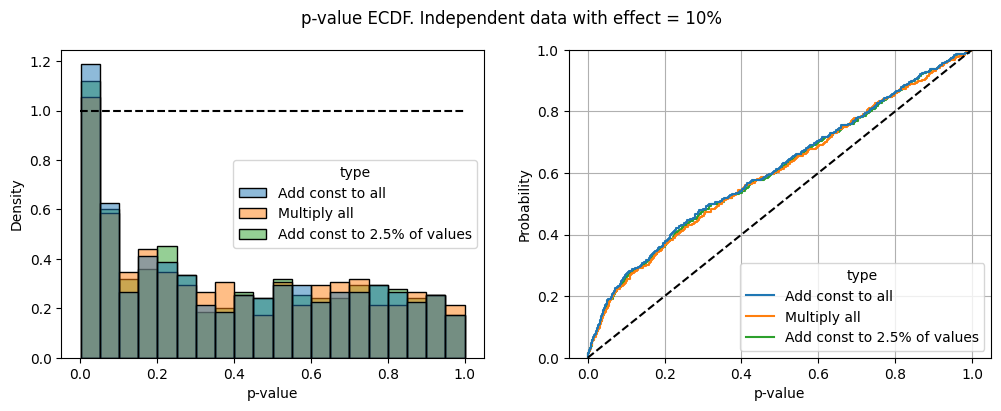

In [72]:
# Importing data
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales = read_database('2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])

begin_date = datetime(2022, 3, 21) 
end_date = datetime(2022, 3, 28)

def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(data=pvalues, x='pvalue', hue='type', ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(data=pvalues, x='pvalue', hue='type', ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()
    
def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = ttest_ind(a, b)
    return int(pvalue < alpha)

sample_size = 1000

df_users = df_sales[df_sales['date'] < end_date][['user_id']]
df_sales_hist = df_sales[(df_sales['date'] >= begin_date) & (df_sales['date'] < end_date)][['user_id','price']] \
    .groupby('user_id').price.sum().reset_index()
grouped_sales = df_users \
    .merge(df_sales_hist, how='left', on='user_id') \
    .fillna(0) \
    .groupby('user_id')['price'].sum().reset_index()

p_values = pd.DataFrame({'p_value': [], 'type': []})
p_values1 = {'pvalue':[], 'type':'Add const to all'}
p_values2 = {'pvalue':[], 'type':'Multiply all'}
p_values3 = {'pvalue':[], 'type':'Add const to 2.5% of values'}

result_ab1 = []
result_ab2 = []
result_ab3 = []

for _ in range(500):
    # Generating groups of users to run a test on
    group_a, group_b = [grouped_sales['user_id'].drop_duplicates() \
        .sample(2 * sample_size, replace=False) \
        .iloc[i-1000:i] for i in range(sample_size, 3 * sample_size, sample_size)] # <-- 2 samples
    
    mean = grouped_sales['price'].mean()
    
    sales_a = grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b = grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    
    # Method 1: adding effect to all values in sample b
    sales_b1 = sales_b.copy() + (0.1 * mean)
    p_val1 = ttest_ind(sales_a, sales_b1).pvalue
    p_values1['pvalue'].append(p_val1)
    
    # Method 2: multiplying all values in sample b by (1 + effect)
    sales_b2 = sales_b.copy() * 1.1
    p_val2 = ttest_ind(sales_a, sales_b2).pvalue
    p_values2['pvalue'].append(p_val2)
    
    # Method 3: adding effect to 2.5% of values in sample b
    sales_b3 = sales_b.copy()
    num_indices_to_update = int(len(sales_b3) * 0.025)
    indices_to_update = sales_b3.sample(num_indices_to_update, replace=False).index
    sales_b3.loc[indices_to_update] += (0.1 * mean) * sample_size / num_indices_to_update

    p_val3 = ttest_ind(sales_a, sales_b3).pvalue
    p_values3['pvalue'].append(p_val3)
    
    result_ab1.append(check_ttest(sales_a, sales_b1))
    result_ab2.append(check_ttest(sales_a, sales_b2))
    result_ab3.append(check_ttest(sales_a, sales_b3))

p_values = pd.concat([p_values, pd.DataFrame(p_values1), pd.DataFrame(p_values2), pd.DataFrame(p_values3)], ignore_index=True)
# p_values = p_values.append(pd.DataFrame(p_values1))
# p_values = p_values.append(pd.DataFrame(p_values2))
# p_values = p_values.append(pd.DataFrame(p_values3))

second_errors1 = round((1 - np.mean(result_ab1)), 3)
second_errors2 = round((1 - np.mean(result_ab2)), 3)
second_errors3 = round((1 - np.mean(result_ab3)), 3)

# Printing out actual values of second-type errors
print(f'Beta of method 1 = {second_errors1}, beta of method 2 = {second_errors2}, beta of method 3 = {second_errors3}')

# Plotting ECDF
plot_pvalue_ecdf(p_values, 'p-value ECDF. Independent data with effect = 10%')

### ExperimentsService метод _estimate_errors

In [ ]:
# Напишем метод _estimate_errors класса ExperimentsService. Описание метода есть в шаблоне решения ниже.

import numpy as np
import pandas as pd
from pydantic import BaseModel
from scipy import stats


class Design(BaseModel):
    """Дата-класс с описание параметров эксперимента.
    
    statistical_test - тип статтеста. ['ttest']
    effect - размер эффекта в процентах
    alpha - уровень значимости
    beta - допустимая вероятность ошибки II рода
    sample_size - размер групп
    """
    statistical_test: str = 'ttest'
    effect: float
    alpha: float = 0.05
    beta: float = 0.1
    sample_size: int


class ExperimentsService:

    def get_pvalue(self, metrics_a_group, metrics_b_group, design):
        """Применяет статтест, возвращает pvalue.
        
        :param metrics_a_group (np.array): массив значений метрик группы A
        :param metrics_a_group (np.array): массив значений метрик группы B
        :param design (Design): объект с данными, описывающий параметры эксперимента
        :return (float): значение p-value
        """
        if design.statistical_test == 'ttest':
            _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
            return pvalue
        else:
            raise ValueError('Неверный design.statistical_test')

    def _create_group_generator(self, metrics, sample_size, n_iter):
        """Генератор случайных групп.

        :param metrics (pd.DataFame): таблица с метриками, columns=['user_id', 'metric'].
        :param sample_size (int): размер групп (количество пользователей в группе).
        :param n_iter (int): количество итераций генерирования случайных групп.
        :return (np.array, np.array): два массива со значениями метрик в группах.
        """
        user_ids = metrics['user_id'].unique()
        for _ in range(n_iter):
            a_user_ids, b_user_ids = np.random.choice(user_ids, (2, sample_size), False)
            a_metric_values = metrics.loc[metrics['user_id'].isin(a_user_ids), 'metric'].values
            b_metric_values = metrics.loc[metrics['user_id'].isin(b_user_ids), 'metric'].values
            yield a_metric_values, b_metric_values

    def _estimate_errors(self, group_generator, design, effect_add_type):
        """Оцениваем вероятности ошибок I и II рода.

        :param group_generator: генератор значений метрик для двух групп.
        :param design (Design): объект с данными, описывающий параметры эксперимента.
        :param effect_add_type (str): способ добавления эффекта для группы B.
            - 'all_const' - увеличить всем значениям в группе B на константу (b_metric_values.mean() * effect / 100).
            - 'all_percent' - увеличить всем значениям в группе B в (1 + effect / 100) раз.
        :return pvalues_aa (list[float]), pvalues_ab (list[float]), first_type_error (float), second_type_error (float):
            - pvalues_aa, pvalues_ab - списки со значениями pvalue
            - first_type_error, second_type_error - оценки вероятностей ошибок I и II рода.
        """
        pvalues_aa = []
        pvalues_ab = []

        for a_metric_val, b_metric_val in group_generator:
            pvalues_aa.append(self.get_pvalue(a_metric_val, b_metric_val, design))
            b_metric_val_with_effect = b_metric_val.copy()
            if effect_add_type == 'all_const':
                b_metric_val_with_effect += b_metric_val_with_effect * design.effect / 100
            elif effect_add_type == 'all_percent':
                b_metric_val_with_effect *= (1 + design.effect/100)
            pvalues_ab.append(self.get_pvalue(a_metric_val, b_metric_val_with_effect, design))
        first_type_error = np.mean(np.array(pvalues_aa) < design.alpha)  # формирование булевого массива (pvalue_aa < 0.05) каждый p-value сравнивается с уровнем значимости
        second_type_error = np.mean(np.array(pvalues_ab) >= design.alpha) # аналогично только для ошибки второго рода когда пропускаем альтер гипотезу хотя оно верное
        return pvalues_aa, pvalues_ab, first_type_error, second_type_error

        

    def estimate_errors(self, metrics, design, effect_add_type, n_iter):
        """Оцениваем вероятности ошибок I и II рода.

        :param metrics (pd.DataFame): таблица с метриками, columns=['user_id', 'metric'].
        :param design (Design): объект с данными, описывающий параметры эксперимента.
        :param effect_add_type (str): способ добавления эффекта для группы B.
            - 'all_const' - увеличить всем значениям в группе B на константу (b_metric_values.mean() * effect / 100).
            - 'all_percent' - увеличить всем значениям в группе B в (1 + effect / 100) раз.
        :param n_iter (int): количество итераций генерирования случайных групп.
        :return pvalues_aa (list[float]), pvalues_ab (list[float]), first_type_error (float), second_type_error (float):
            - pvalues_aa, pvalues_ab - списки со значениями pvalue
            - first_type_error, second_type_error - оценки вероятностей ошибок I и II рода.
        """
        group_generator = self._create_group_generator(metrics, design.sample_size, n_iter)
        return self._estimate_errors(group_generator, design, effect_add_type)


if __name__ == '__main__':
    _a = np.array([1., 2, 3, 4, 5])
    _b = np.array([1., 2, 3, 4, 10])
    group_generator = ([a, b] for a, b in ((_a, _b),))
    design = Design(effect=50., sample_size=5)
    effect_add_type = 'all_percent'

    ideal_pvalues_aa = [0.579584]
    ideal_pvalues_ab = [0.260024]
    ideal_first_type_error = 0.
    ideal_second_type_error = 1.

    experiments_service = ExperimentsService()
    pvalues_aa, pvalues_ab, first_type_error, second_type_error = experiments_service._estimate_errors(
        group_generator, design, effect_add_type
    )
    np.testing.assert_almost_equal(ideal_pvalues_aa, pvalues_aa, decimal=4)
    np.testing.assert_almost_equal(ideal_pvalues_ab, pvalues_ab, decimal=4)
    assert ideal_first_type_error == first_type_error
    assert ideal_second_type_error == second_type_error
    print('simple test passed')

simple test passed
